In [1]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plotter

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image

from collections import OrderedDict 

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, ToPILImage, CenterCrop, RandomResizedCrop
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.datasets import ImageFolder

In [2]:
ROOT = "/kaggle/input/animal-image-classification-dataset/Animals"
device = "cuda" if torch.cuda.is_available() else "cpu"
inception = inception_v3(weights = Inception_V3_Weights.DEFAULT)
inception.fc = nn.Identity()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 198MB/s] 


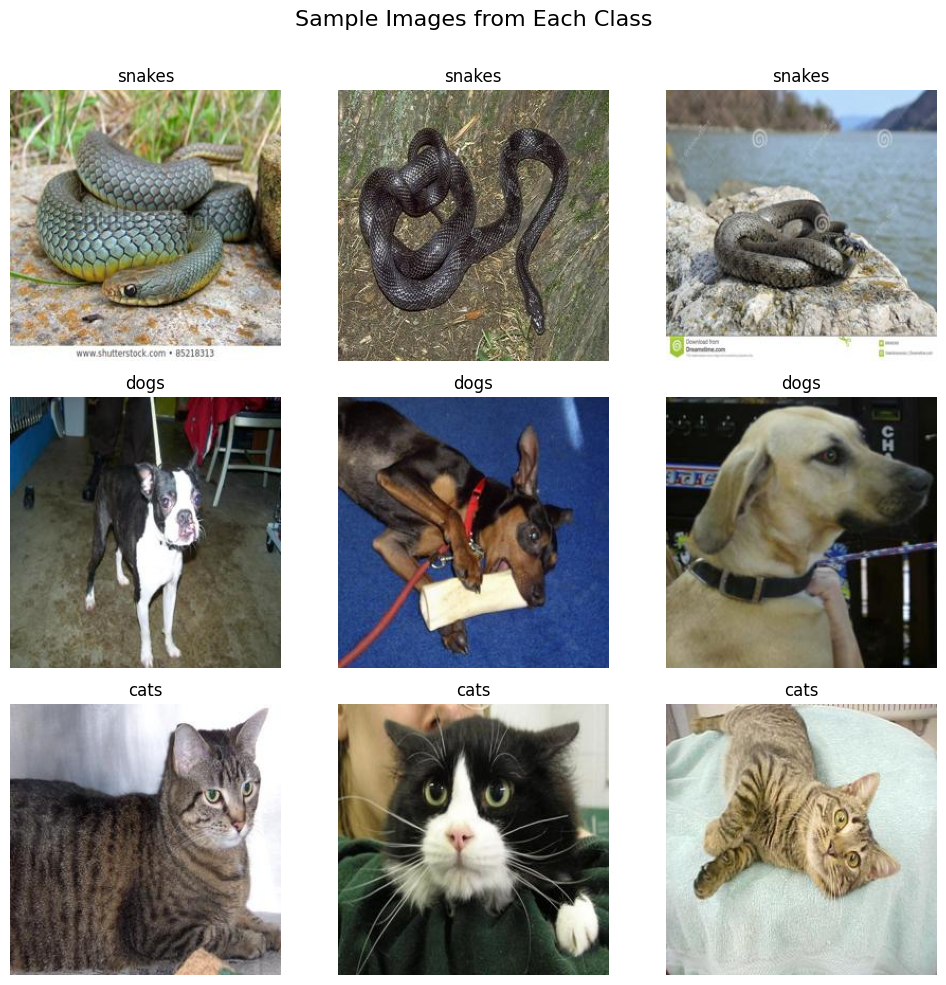

In [3]:
fig, axes = plotter.subplots(3, 3, figsize=(10, 10))
fig.suptitle("Sample Images from Each Class", fontsize=16)
class_folders = [d for d in os.listdir(ROOT) if os.path.isdir(os.path.join(ROOT, d))]

for i, class_name in enumerate(class_folders):
    class_folder_path = os.path.join(ROOT, class_name)
    
    image_files = [f for f in os.listdir(class_folder_path) if os.path.isfile(os.path.join(class_folder_path, f))][:3]
    
    for j, img_file in enumerate(image_files):
        img_path = os.path.join(class_folder_path, img_file)
        img = Image.open(img_path)
        ax = axes[i, j]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(class_name)

# Adjust layout and display the grid
plotter.tight_layout()
plotter.subplots_adjust(top=0.9)

In [4]:
normalizer = Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
composer = Compose([Resize((299, 299)), CenterCrop(224), RandomResizedCrop((200, 200)) ,ToTensor(), normalizer])
data = ImageFolder(root = ROOT, transform = composer)

In [5]:
def process_image(img, featurizer, composer, device = "cuda"):
    img = Image.open(img)
    processed = composer(img).unsqueeze(0)
    processed = processed.to("cuda")
    with torch.no_grad():
        featurizer.eval()
        processed = featurizer(processed)
    return processed
    
def featurize_dataset(data, featurizer, dataset, device = "cpu"):
    features = None
    labels = None
    featurizer.eval()
    featurizer.to(device)
    for index, (feature, label) in enumerate(data):
        #slower, but I want to be obstinate
        feature = feature.unsqueeze(0)
        with torch.no_grad():
            output = featurizer(feature.to(device))
        if index == 0:
            features = output.detach().cpu()
            labels = torch.tensor([label])
        else:
            features = torch.cat([features, output.detach().cpu()])
            labels = torch.cat([labels, torch.tensor([label])])
    dataset = TensorDataset(features, labels)
    return dataset

In [6]:
train, test = random_split(data, [0.8, 0.2])

processed_train = featurize_dataset(train, inception, composer, device)
processed_test = featurize_dataset(test, inception, composer, device)

train_loader = DataLoader(processed_train, batch_size = 32, shuffle = True)
test_loader = DataLoader(processed_test, batch_size = 32)


loss = nn.CrossEntropyLoss(reduction = "mean")
learner = nn.Sequential(OrderedDict({"output_fc": nn.Linear(2048, 3)}))
learner.to(device)
optimizer = optim.Adam(learner.parameters(), lr = 1e-2)

In [7]:
#training the model
EPOCHS = 6

training_losses = []
validation_losses = []

for epoch in range(EPOCHS):
    #train step
    learner.train()
    for index, (feature_batch, label_batch) in enumerate(train_loader):
        batch_loss_t = []
        features = feature_batch.to(device)
        labels = label_batch.to(device)
        preds = learner(features)
        try:
            curr_t_loss = loss(preds.squeeze(), labels)
        except:
            curr_t_loss = loss(preds, labels)
        curr_t_loss.backward() #perform backpropagation
        optimizer.step()
        optimizer.zero_grad() #we might want to move this outside if it hurts model perf
        batch_loss_t.append(curr_t_loss.item())
    training_losses.append(np.mean(batch_loss_t))
    print(f"Epoch: {epoch + 1}")
    print(f"Current, averaged TRAINING loss over mini-batches is: {training_losses[-1]}")
    #test step
    with torch.no_grad():
        learner.eval()
        for index, (feature_batch, label_batch) in enumerate(test_loader):
            batch_loss_test = []
            features = feature_batch.to(device)
            labels = label_batch.to(device)
            preds = learner(features)
            try:
                curr_test_loss = loss(preds.squeeze(), labels)
            except:
                curr_test_loss = loss(preds, labels)
            batch_loss_test.append(curr_test_loss.item())
        validation_losses.append(np.mean(batch_loss_test))
    print(f"Current, averaged TEST loss over mini-batches is: {validation_losses[-1]}")


Epoch: 1
Current, averaged TRAINING loss over mini-batches is: 0.2791999876499176
Current, averaged TEST loss over mini-batches is: 0.5042814612388611
Epoch: 2
Current, averaged TRAINING loss over mini-batches is: 0.04713509976863861
Current, averaged TEST loss over mini-batches is: 0.28383687138557434
Epoch: 3
Current, averaged TRAINING loss over mini-batches is: 0.0528554692864418
Current, averaged TEST loss over mini-batches is: 0.34436342120170593
Epoch: 4
Current, averaged TRAINING loss over mini-batches is: 0.29812154173851013
Current, averaged TEST loss over mini-batches is: 1.3349370956420898
Epoch: 5
Current, averaged TRAINING loss over mini-batches is: 0.4351074695587158
Current, averaged TEST loss over mini-batches is: 1.4344630241394043
Epoch: 6
Current, averaged TRAINING loss over mini-batches is: 0.017724590376019478
Current, averaged TEST loss over mini-batches is: 1.9263811111450195


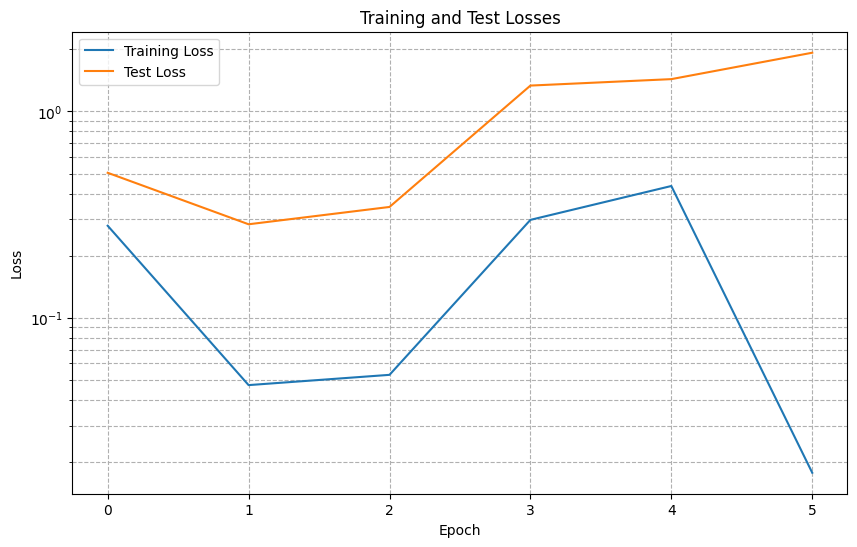

In [8]:
def plot_losses(train_losses, test_losses):
    plotter.figure(figsize=(10, 6))
    
    plotter.plot(train_losses, label='Training Loss')
    plotter.plot(test_losses, label='Test Loss')
    
    plotter.yscale('log') 
    plotter.xlabel('Epoch')
    plotter.ylabel('Loss')
    plotter.title('Training and Test Losses')
    plotter.legend()
    plotter.grid(True, which="both", ls="--") 

plot_losses(training_losses, validation_losses)

In [9]:
def accuracy(features, labels, device = device, learner = learner, threshold = .5):
    learner.eval()
    preds = learner(features.to(device))
    labels = labels.to(device)

    nsamples, ndims = preds.shape
    if ndims > 1:
        _, predicted = torch.max(preds, 1)
    else:
        ndims += 1
        if isinstance(learner, nn.Sequential) and isinstance(learner[-1], nn.Sigmoid):
            predicted = (preds > threshold).long()
        else:
            predicted = (torch.sigmoid(preds) > threshold).long()
  
    result = []
    for _class in range(ndims):
        nclass = (labels == _class).sum().item()
        ncorrect = (predicted[labels == _class] == _class).sum().item()
        result.append((ncorrect, nclass))
    return torch.tensor(result)

def apply_loader(loader, func, reduction = "sum"):
      results = [func(feat, label) for i, (feat, label) in enumerate(loader)]
      results = torch.stack(results, axis = 0)
      if reduction == "sum":
        results = results.sum(axis = 0)
      elif reduction == "mean":
        results = results.float().mean(axis = 0)
      
      return results 

accuracy_scores = apply_loader(test_loader, accuracy)
total = accuracy_scores.sum(axis = 0)
print(f"The accuracy percentage is: {(total[0]/total[1]) * 100}%" )

The accuracy percentage is: 93.16666412353516%


In [10]:
label_mapping = data.class_to_idx
label_mapping = {v: k for k, v in label_mapping.items()}
label_mapping

{0: 'cats', 1: 'dogs', 2: 'snakes'}

In [11]:
def predict_img(learner, img, preprocess_fn = process_image, featurizer = inception, composer = composer, mapping = label_mapping, device = device):
    featurizer.to(device)
    plotter.imshow(plotter.imread(img))
    data = preprocess_fn(img, featurizer, composer, device)
    data.to(device)
    with torch.no_grad():
        learner.eval()
        learner.to(device)
        pred = learner(data)
    confidence, idx = torch.max(pred, 1)
    return f"The image shown is of a {mapping[idx.item()][:-1]}"

'The image shown is of a cat'

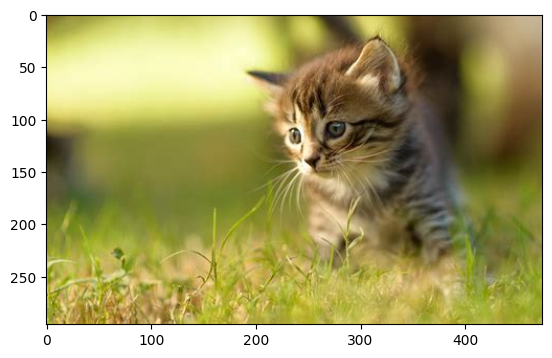

In [12]:
TEST_LOCATION = "/kaggle/input/some-cat-image/cat_img.jpg"
predict_img(learner, TEST_LOCATION)

In [13]:
print("We're done!")
print("This is what we can do!")

We're done!
This is what we can do!
